# Coursera Capstone Project - The battle of neighborhood

## Find the safest place and find living place in Phoenix, AZ


# Business Problem
This project is to find out the safest zip code in Phoenix area based on the total crime dataset in Phoenix, explore the neighborhoods of each zip code to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering. I live in Phoenix and I'm curious how safe my place is and this will be helpful for someone who are looking to relocate to Phoenix, AZ

# Data

Following data sources will be needed to extract/generate the required information:

* Phoenix Crime Dataset from 2017 to 2019: A dataset consisting of the crime statistics of each zip code in Phoenix.<br />Dataset URL: https://www.phoenixopendata.com/dataset/crime-data
* Zip code with co-ordinates. <br />Dataset URL: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/

#### Phoenix Crime Data
About this file

* INC NUMBER : Incident number
* OCCURRED ON : Start time
* OCCURRED TO : End time
* UCR CRIME CATEGORY : Crime type
* 100 BLOCK ADDR : Address
* ZIP : Zip Code
* PREMISE TYPE : Premise type

#### Zip code co-ordinates
About this file

* Zip
* City
* State
* Latitude
* Longitude
* Timezone
* Daylight savings time flag
* geopoint

import all the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
# Read in the data 
df_crime = pd.read_csv("crime-data_crime-data_crimestat.csv")
df_crime.head()

,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE
0,2.019000e+14,01/01/2017 00:00,02/28/2017 00:00,RAPE,74XX W CATALINA DR,85033.0,SCHOOL-ELEMENTARY/SECONDARY
1,2.017000e+14,01/01/2017 00:00,01/31/2017 21:30,LARCENY-THEFT,47XX E MCDOWELL RD,85008.0,APARTMENT
2,2.017000e+14,01/01/2017 00:00,01/04/2017 17:24,LARCENY-THEFT,19XX N 26TH PL,85008.0,PARKING LOT
3,2.017000e+14,01/01/2017 00:00,01/03/2017 00:00,LARCENY-THEFT,14XX E OCOTILLO RD,85014.0,APARTMENT
4,2.017000e+14,01/01/2017 00:00,NaN,LARCENY-THEFT,47XX E ANGELA DR,85032.0,FENCED RESIDENTIAL YARD


**Total of 200284 crime records are read**

In [3]:
df_crime.shape

(200284, 7)

**Found some null values in ZIP column -> Dropped**

In [4]:
df_crime.dropna(subset=['ZIP'], inplace=True)

**5 null ZIP records dropped**

In [5]:
df_crime.shape

(200279, 7)

**Convert ZIP to int**

In [6]:
df_crime['ZIP'] = df_crime['ZIP'].astype(int)

In [7]:
# Shape of the data frame
df_crime.head()

,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE
0,2.019000e+14,01/01/2017 00:00,02/28/2017 00:00,RAPE,74XX W CATALINA DR,85033,SCHOOL-ELEMENTARY/SECONDARY
1,2.017000e+14,01/01/2017 00:00,01/31/2017 21:30,LARCENY-THEFT,47XX E MCDOWELL RD,85008,APARTMENT
2,2.017000e+14,01/01/2017 00:00,01/04/2017 17:24,LARCENY-THEFT,19XX N 26TH PL,85008,PARKING LOT
3,2.017000e+14,01/01/2017 00:00,01/03/2017 00:00,LARCENY-THEFT,14XX E OCOTILLO RD,85014,APARTMENT
4,2.017000e+14,01/01/2017 00:00,NaN,LARCENY-THEFT,47XX E ANGELA DR,85032,FENCED RESIDENTIAL YARD


**Rename column names**

In [8]:
df_crime.columns = ['id', 'start_time','end_time','crime_type','address','zip_code','premise_type']
df_crime.head()

,id,start_time,end_time,crime_type,address,zip_code,premise_type
0,2.019000e+14,01/01/2017 00:00,02/28/2017 00:00,RAPE,74XX W CATALINA DR,85033,SCHOOL-ELEMENTARY/SECONDARY
1,2.017000e+14,01/01/2017 00:00,01/31/2017 21:30,LARCENY-THEFT,47XX E MCDOWELL RD,85008,APARTMENT
2,2.017000e+14,01/01/2017 00:00,01/04/2017 17:24,LARCENY-THEFT,19XX N 26TH PL,85008,PARKING LOT
3,2.017000e+14,01/01/2017 00:00,01/03/2017 00:00,LARCENY-THEFT,14XX E OCOTILLO RD,85014,APARTMENT
4,2.017000e+14,01/01/2017 00:00,NaN,LARCENY-THEFT,47XX E ANGELA DR,85032,FENCED RESIDENTIAL YARD


**View the information of the dataset**

In [9]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200279 entries, 0 to 200283
Data columns (total 7 columns):
id              200279 non-null float64
start_time      200075 non-null object
end_time        136507 non-null object
crime_type      200279 non-null object
address         200279 non-null object
zip_code        200279 non-null int64
premise_type    199324 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 12.2+ MB


**Total number of crimes in each Zip code**

In [10]:
df_crime['zip_code'].value_counts()

85015    10066
85008     9300
85009     9020
85041     8946
85051     8730
85017     8379
85035     7576
85043     7175
85021     6966
85033     6700
85029     6028
85032     5972
85040     5765
85023     5675
85016     5537
85042     5313
85031     5069
85022     5041
85037     4665
85019     4471
85034     4458
85020     4331
85006     4255
85013     4182
85339     3762
85027     3743
85018     3441
85007     3408
85014     3350
85053     2898
85044     2844
85003     2589
85004     2562
85353     2109
85254     2008
85085     1557
85308     1364
85050     1320
85012     1319
85048     1312
85024     1201
85028     1066
85054      853
85306      645
85086      451
85310      448
85307      418
85083      410
85331      408
85304      402
85087      150
85045      144
85251       91
85253       62
85255       61
85301       47
85260       25
85302       21
85396       18
85282       12
85323       11
85303       10
85281        9
85338        9
85392        8
85383        7
85202     

**Total crimes per category type**

In [11]:
df_crime['crime_type'].value_counts()

LARCENY-THEFT                            102626
BURGLARY                                  29640
MOTOR VEHICLE THEFT                       20524
DRUG OFFENSE                              17866
AGGRAVATED ASSAULT                        16218
ROBBERY                                    8638
RAPE                                       2960
ARSON                                      1419
MURDER AND NON-NEGLIGENT MANSLAUGHTER       388
Name: crime_type, dtype: int64

**Crossing the table to view the no. of crimes for each crime type in each zip code**

In [12]:
phoenix_crime = pd.crosstab(df_crime.zip_code,df_crime.crime_type)
phoenix_crime.head()

crime_type,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY
zip_code,,,,,,,,,
85003,264,26,302,355,1227,205,3,80,127
85004,228,11,248,198,1517,163,6,50,141
85006,432,51,712,439,1868,395,12,137,209
85007,452,38,388,573,1378,288,11,76,204
85008,831,84,1128,943,4773,924,25,195,397


In [13]:
phoenix_crime.reset_index(inplace = True)
phoenix_crime.head()

crime_type,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY
0,85003,264,26,302,355,1227,205,3,80,127
1,85004,228,11,248,198,1517,163,6,50,141
2,85006,432,51,712,439,1868,395,12,137,209
3,85007,452,38,388,573,1378,288,11,76,204
4,85008,831,84,1128,943,4773,924,25,195,397


In [14]:
phoenix_crime.shape

(103, 10)

**Count the total number of crime per each zip code**

In [15]:
# Total crimes per zip code
phoenix_crime['total'] = phoenix_crime.drop('zip_code', axis = 1).sum(axis = 1)
phoenix_crime.head()

crime_type,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total
0,85003,264,26,302,355,1227,205,3,80,127,2589
1,85004,228,11,248,198,1517,163,6,50,141,2562
2,85006,432,51,712,439,1868,395,12,137,209,4255
3,85007,452,38,388,573,1378,288,11,76,204,3408
4,85008,831,84,1128,943,4773,924,25,195,397,9300


**Load the file for zip code data with co-ordinates**

In [16]:
filename='us-zip-code-latitude-and-longitude.csv'

df_zip = pd.read_csv(filename, sep=';')
df_zip = df_zip[['Zip', 'City', 'State', 'Latitude', 'Longitude']]
df_zip = df_zip.rename(columns = {"Zip":"zip_code", "Latitude":"lat", "Longitude":"lng", "City":"city"})

print("Dataframe shape: ", df_zip.shape)

df_zip.head(100)

Dataframe shape:  (78, 5)


,zip_code,city,State,lat,lng
0,85074,Phoenix,AZ,33.276539,-112.187170
1,85061,Phoenix,AZ,33.276539,-112.187170
2,85001,Phoenix,AZ,33.703967,-112.351835
3,85031,Phoenix,AZ,33.493496,-112.171080
4,85041,Phoenix,AZ,33.386995,-112.100760
5,85075,Phoenix,AZ,33.276539,-112.187170
6,85013,Phoenix,AZ,33.507110,-112.084830
7,85017,Phoenix,AZ,33.514092,-112.122850
8,85068,Phoenix,AZ,33.276539,-112.187170
9,85023,Phoenix,AZ,33.638271,-112.093410


**Found some duplicates in latitude and longitude so, removed those**

In [17]:
df_zip = df_zip.drop_duplicates(subset=['lat', 'lng'], keep=False)

print("Dataframe shape: ", df_zip.shape)
df_zip.reset_index(drop=True, inplace=True)
df_zip.head(100)

Dataframe shape:  (42, 5)


,zip_code,city,State,lat,lng
0,85001,Phoenix,AZ,33.703967,-112.351835
1,85031,Phoenix,AZ,33.493496,-112.171080
2,85041,Phoenix,AZ,33.386995,-112.100760
3,85013,Phoenix,AZ,33.507110,-112.084830
4,85017,Phoenix,AZ,33.514092,-112.122850
5,85023,Phoenix,AZ,33.638271,-112.093410
6,85042,Phoenix,AZ,33.381234,-112.027663
7,85032,Phoenix,AZ,33.624140,-112.004160
8,85051,Phoenix,AZ,33.559783,-112.133610
9,85035,Phoenix,AZ,33.472492,-112.187500


In [18]:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
zip_code    42 non-null int64
city        42 non-null object
State       42 non-null object
lat         42 non-null float64
lng         42 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.8+ KB


**Merge two data into one table for crime data analysis**

In [19]:
phx_crime = pd.merge(phoenix_crime, df_zip, on='zip_code')
phx_crime.head()

,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total,city,State,lat,lng
0,85003,264,26,302,355,1227,205,3,80,127,2589,Phoenix,AZ,33.451143,-112.07838
1,85004,228,11,248,198,1517,163,6,50,141,2562,Phoenix,AZ,33.451093,-112.07057
2,85006,432,51,712,439,1868,395,12,137,209,4255,Phoenix,AZ,33.466392,-112.04875
3,85007,452,38,388,573,1378,288,11,76,204,3408,Phoenix,AZ,33.449995,-112.09024
4,85008,831,84,1128,943,4773,924,25,195,397,9300,Phoenix,AZ,33.466393,-112.00080


In [20]:
phx_crime.shape

(40, 15)

# Methodology

* Exploratory Data Analysis: Visualise the crime rates in the City of Phoenix based on zip codes to idenity the safest zip code and pick up one zip code to figure out what each type of crime happened in that specific zip code and eventually find the 10 most common venues in each zip code.

* Modelling: To help people find similar neighborhoods in the safest zip code we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 10 for this project that will cluster the 40 neighborhoods into 10 clusters. The reason to conduct a K- means clustering is to cluster zip codes with similar venues together so that people can find the area of their interests based on the venues/amenities around each neighborhood.

### Exploratory Data Analysis
#### Descriptive statistics of the data

In [21]:
phoenix_crime.describe()

crime_type,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,85181.660194,157.456311,13.776699,287.766990,173.456311,996.368932,199.262136,3.766990,28.737864,83.864078,1944.456311
std,134.515001,239.474948,20.672484,398.608885,286.890899,1399.876381,315.803052,6.268821,41.318457,139.336386,2778.276362
min,85003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,85034.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,85215.000000,7.000000,1.000000,26.000000,8.000000,66.000000,7.000000,0.000000,5.000000,3.000000,144.000000
75%,85301.500000,277.000000,25.000000,530.000000,248.500000,1786.500000,311.000000,6.500000,57.500000,139.000000,3592.000000
max,85396.000000,884.000000,84.000000,1439.000000,1217.000000,5549.000000,1373.000000,26.000000,195.000000,591.000000,10066.000000


In [22]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


**Plot the 10 zip codes with the highest number of crimes**

In [23]:
phx_crime.sort_values(['total'], ascending = False, axis = 0, inplace = True )

df_top10 = phx_crime.head(10) 
df_top10

,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total,city,State,lat,lng
9,85015,862,79,1198,919,5549,728,25,123,583,10066,Phoenix,AZ,33.506890,-112.10262
4,85008,831,84,1128,943,4773,924,25,195,397,9300,Phoenix,AZ,33.466393,-112.00080
5,85009,884,75,1219,1123,3706,1373,26,103,511,9020,Phoenix,AZ,33.456350,-112.12378
29,85041,715,64,1439,557,4540,1194,21,82,334,8946,Phoenix,AZ,33.386995,-112.10076
36,85051,698,66,1212,978,4423,766,17,134,436,8730,Phoenix,AZ,33.559783,-112.13361
11,85017,838,51,1071,1217,3671,786,12,142,591,8379,Phoenix,AZ,33.514092,-112.12285
26,85035,588,33,953,683,3844,986,17,67,405,7576,Phoenix,AZ,33.472492,-112.18750
31,85043,557,33,1018,604,3505,1079,12,74,293,7175,Phoenix,AZ,33.435405,-112.20009
15,85021,657,49,1067,955,3255,572,14,92,305,6966,Phoenix,AZ,33.559437,-112.09281
24,85033,651,51,1113,572,2755,1075,22,84,377,6700,Phoenix,AZ,33.496091,-112.21405


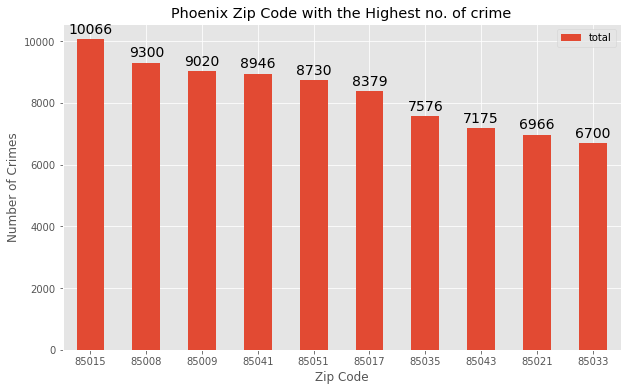

In [24]:
df_tt = df_top10[['zip_code','total']]

df_tt.set_index('zip_code',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Zip Code') # add y-label to the plot
ax.set_title('Phoenix Zip Code with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**Plot the 10 zip codes with the lowest number of crimes**

In [25]:
phx_crime.sort_values(['total'], ascending = True, axis = 0, inplace = True )

df_bot10 = phx_crime.head(10) 
df_bot10

,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total,city,State,lat,lng
33,85045,10,1,32,7,66,22,1,5,0,144,Phoenix,AZ,33.299740,-112.09812
38,85054,33,1,120,19,610,47,0,15,8,853,Phoenix,AZ,33.689558,-111.96463
20,85028,44,12,268,45,618,50,0,10,19,1066,Phoenix,AZ,33.585037,-112.00815
18,85024,72,10,219,78,670,108,4,13,27,1201,Phoenix,AZ,33.675564,-112.04717
34,85048,71,9,238,82,770,102,0,20,20,1312,Phoenix,AZ,33.302098,-112.02477
6,85012,82,6,231,101,749,77,2,20,51,1319,Phoenix,AZ,33.505251,-112.07030
35,85050,80,8,295,81,740,75,3,20,18,1320,Phoenix,AZ,33.683603,-111.99271
39,85085,67,6,193,45,1120,91,2,15,18,1557,Phoenix,AZ,33.777760,-112.07945
1,85004,228,11,248,198,1517,163,6,50,141,2562,Phoenix,AZ,33.451093,-112.07057
0,85003,264,26,302,355,1227,205,3,80,127,2589,Phoenix,AZ,33.451143,-112.07838


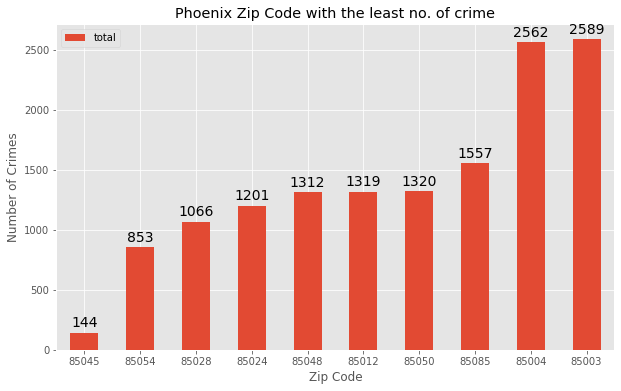

In [26]:
df_bt = df_bot10[['zip_code','total']]

df_bt.set_index('zip_code',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Zip Code') # add y-label to the plot
ax.set_title('Phoenix Zip Code with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [27]:
df_bot10.head(10)

,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total,city,State,lat,lng
33,85045,10,1,32,7,66,22,1,5,0,144,Phoenix,AZ,33.299740,-112.09812
38,85054,33,1,120,19,610,47,0,15,8,853,Phoenix,AZ,33.689558,-111.96463
20,85028,44,12,268,45,618,50,0,10,19,1066,Phoenix,AZ,33.585037,-112.00815
18,85024,72,10,219,78,670,108,4,13,27,1201,Phoenix,AZ,33.675564,-112.04717
34,85048,71,9,238,82,770,102,0,20,20,1312,Phoenix,AZ,33.302098,-112.02477
6,85012,82,6,231,101,749,77,2,20,51,1319,Phoenix,AZ,33.505251,-112.07030
35,85050,80,8,295,81,740,75,3,20,18,1320,Phoenix,AZ,33.683603,-111.99271
39,85085,67,6,193,45,1120,91,2,15,18,1557,Phoenix,AZ,33.777760,-112.07945
1,85004,228,11,248,198,1517,163,6,50,141,2562,Phoenix,AZ,33.451093,-112.07057
0,85003,264,26,302,355,1227,205,3,80,127,2589,Phoenix,AZ,33.451143,-112.07838


In [28]:
df_bc1 =  df_bot10[df_bot10['zip_code'] == 85024]
df_bc1.head()

,zip_code,AGGRAVATED ASSAULT,ARSON,BURGLARY,DRUG OFFENSE,LARCENY-THEFT,MOTOR VEHICLE THEFT,MURDER AND NON-NEGLIGENT MANSLAUGHTER,RAPE,ROBBERY,total,city,State,lat,lng
18,85024,72,10,219,78,670,108,4,13,27,1201,Phoenix,AZ,33.675564,-112.04717


**Picked up 85024 zip code to figure out what kinds of crime had happened. This is where I live right now and it looks like it's ranked at 6th out of 42 zip codes in terms of lowest number of crimes**

Found that Theft is most common crimes in 85024

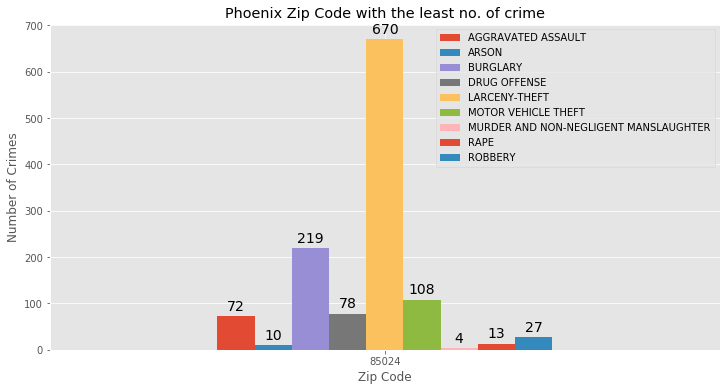

In [29]:
df_bc1 =  df_bot10[df_bot10['zip_code'] == 85024]

df_bc = df_bc1[['zip_code','AGGRAVATED ASSAULT','ARSON','BURGLARY','DRUG OFFENSE',
                 'LARCENY-THEFT','MOTOR VEHICLE THEFT','MURDER AND NON-NEGLIGENT MANSLAUGHTER',
                 'RAPE', 'ROBBERY']]


df_bc.set_index('zip_code',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(12, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Zip Code') # add y-label to the plot
ax.set_title('Phoenix Zip Code with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**Use geopy library to get the latitude and longitude values of Phoenix.**

In [30]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Phoenix, Arizona'

geolocator = Nominatim(user_agent="phoenix_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Phoenix are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Phoenix are 33.4484367, -112.0741417.


**Create map of Phoenix using latitude and longitude values and add markers to map too.**

In [31]:
import folium # map rendering library
map_phoenix = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, zip_code, city in zip(df_zip['lat'], df_zip['lng'], df_zip['zip_code'], df_zip['city']):
    label = '{}, {}'.format(zip_code, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phoenix)  
    
map_phoenix

We can get 42 zip codes locations in Phoenix

**Define Foursquare Credentials and Version**

In [32]:
CLIENT_ID = 'O3D3UHLO412WYMP5H2FNEFNEVRJRPG0VECERWG5UFUSMI1EO'
CLIENT_SECRET = 'F4BUQX0Y0L5ENBW0V05ZCWV2KKJPBYCJO4YURDDMZOD5XSAT'
VERSION = '20200108'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O3D3UHLO412WYMP5H2FNEFNEVRJRPG0VECERWG5UFUSMI1EO
CLIENT_SECRET:F4BUQX0Y0L5ENBW0V05ZCWV2KKJPBYCJO4YURDDMZOD5XSAT


# Modelling
* Finding all the venues within a 1000 meter radius of each zip codes.
* Perform one hot ecoding on the venues data.
* Grouping the venues by the zip code and calculating their mean.
* Performing a K-means clustering (Defining K = 5)

In [34]:
LIMIT = 100
radius = 1000

def getNearbyVenues(names, latitudes, longitudes, radius=1000, categoryIds=''):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if (categoryIds != ''):
            url = url + '&categoryId={}'
            url = url.format(categoryIds)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
phoenix_venues = getNearbyVenues(
    names=df_zip['zip_code'],
    latitudes=df_zip['lat'],
    longitudes=df_zip['lng'])

85001 33.703967 -112.35183500000001
85031 33.493496 -112.17108
85041 33.386995 -112.10076000000001
85013 33.50711 -112.08483000000001
85017 33.514092 -112.12285
85023 33.638271 -112.09341
85042 33.381234 -112.02766299999999
85032 33.624140000000004 -112.00416000000001
85051 33.559783 -112.13361
85035 33.472491999999995 -112.1875
85020 33.563663 -112.05519
85004 33.451093 -112.07056999999999
85045 33.29974 -112.09812
85029 33.598841 -112.12023
85034 33.437771999999995 -112.0281
85006 33.466392 -112.04875
85015 33.506890000000006 -112.10262
85018 33.498076 -111.98603
85028 33.585037 -112.00815
85053 33.629911 -112.13122
85085 33.77776 -112.07945
85040 33.393322999999995 -112.02857
85050 33.683603000000005 -111.99271
85033 33.496091 -112.21405
85007 33.449995 -112.09024
85012 33.505251 -112.0703
85025 33.422621 -111.72363500000002
85019 33.511992 -112.1417
85037 33.493006 -112.25538999999999
85024 33.675564 -112.04717
85022 33.630497 -112.0521
85021 33.559437 -112.09281000000001
85027 33.

**Let's check the size of the resulting dataframe**

In [37]:
print(phoenix_venues.shape)
phoenix_venues.head()

(1245, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,85001,33.703967,-112.351835,Homero Hermosillo,33.703849,-112.355075,Business Service
1,85001,33.703967,-112.351835,Samii Khan,33.704617,-112.356920,Art Gallery
2,85031,33.493496,-112.171080,American Family Fields of Phoenix,33.492339,-112.172175,Baseball Stadium
3,85031,33.493496,-112.171080,Walgreens,33.494403,-112.169563,Pharmacy
4,85031,33.493496,-112.171080,Wingstop,33.494441,-112.171156,Wings Joint


**Let's check how many venues were returned for each zip code**

In [38]:
phoenix_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
85001,2,2,2,2,2,2
85003,100,100,100,100,100,100
85004,100,100,100,100,100,100
85006,35,35,35,35,35,35
85007,41,41,41,41,41,41
85008,15,15,15,15,15,15
85009,17,17,17,17,17,17
85012,97,97,97,97,97,97
85013,49,49,49,49,49,49


**Let's find how many unique venue we have in Venue category.**

In [39]:
print('There are {} uniques categories.'.format(len(phoenix_venues['Venue Category'].unique())))

There are 221 uniques categories.


<a id='item3'></a>

In [40]:
# one hot encoding
phoenix_onehot = pd.get_dummies(phoenix_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
phoenix_onehot['Neighborhood'] = phoenix_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [phoenix_onehot.columns[-1]] + list(phoenix_onehot.columns[:-1])
phoenix_onehot = phoenix_onehot[fixed_columns]

phoenix_onehot.head()

,Yoga Studio,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Stadium,Comedy Club,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lawyer,Light Rail Station,Lighthouse,Lighting Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Opera House,Optical Shop,Other Great Outdoors,Outlet Store,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Plaza,Pool,Pub,RV Park,Racetrack,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Spa,Sporting Goods Shop,Sports Bar,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Trail,Trailer Park,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2

In [41]:
phoenix_onehot.shape

(1245, 221)

**Now we will group the rows by neighborhood name and by calculating the mean of the frequency of occurence of each category.**

In [42]:
phoenix_grouped = phoenix_onehot.groupby('Neighborhood').mean().reset_index()
phoenix_grouped

,Neighborhood,Yoga Studio,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Stadium,Comedy Club,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lawyer,Light Rail Station,Lighthouse,Lighting Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Night Market,Opera House,Optical Shop,Other Great Outdoors,Outlet Store,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Plaza,Pool,Pub,RV Park,Racetrack,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Spa,Sporting Goods Shop,Sports Bar,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Trail,Trailer Park,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,85001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0

**Here's the new size of grouped dataframe**

In [43]:
phoenix_grouped.shape

(42, 221)

**Let's print out each neighborhood along with the top 5 most common venues**

In [44]:
num_top_venues = 5

for hood in phoenix_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = phoenix_grouped[phoenix_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

                      venue  freq
0          Business Service   0.5
1               Art Gallery   0.5
2                Nail Salon   0.0
3            Mattress Store   0.0
4  Mediterranean Restaurant   0.0


                 venue  freq
0          Coffee Shop  0.10
1          Pizza Place  0.08
2                Hotel  0.07
3  American Restaurant  0.06
4         Cocktail Bar  0.04


                 venue  freq
0          Coffee Shop  0.10
1          Pizza Place  0.07
2                Hotel  0.06
3  American Restaurant  0.05
4         Cocktail Bar  0.04


                venue  freq
0  Mexican Restaurant  0.17
1          Taco Place  0.09
2                Café  0.09
3  Seafood Restaurant  0.06
4   Convenience Store  0.06


                 venue  freq
0  American Restaurant  0.10
1                Hotel  0.07
2   Mexican Restaurant  0.07
3           Food Truck  0.07
4          Coffee Shop  0.05


               venue  freq
0  Convenience Store  0.13
1  Afghan Restaurant  0.13
2     Discount 

**Next we will create a pandas dataframe with the top 10 most common venues in each neighborhood.**

In [45]:
# Function to sort venues in descending order of their frequency.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = phoenix_grouped['Neighborhood']

for ind in np.arange(phoenix_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(phoenix_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(100)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,85001,Art Gallery,Business Service,Women's Store,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run
1,85003,Coffee Shop,Pizza Place,Hotel,American Restaurant,Cocktail Bar,Breakfast Spot,Mexican Restaurant,Music Venue,Art Gallery,Salon / Barbershop
2,85004,Coffee Shop,Pizza Place,Hotel,American Restaurant,Cocktail Bar,Breakfast Spot,Salon / Barbershop,Sandwich Place,Bar,Music Venue
3,85006,Mexican Restaurant,Taco Place,Café,Convenience Store,Seafood Restaurant,Coffee Shop,Pet Service,Park,Discount Store,Supermarket
4,85007,American Restaurant,Food Truck,Mexican Restaurant,Hotel,Coffee Shop,Pizza Place,Art Gallery,Mattress Store,Bank,Food
5,85008,Afghan Restaurant,Convenience Store,Indian Restaurant,New American Restaurant,Discount Store,Dive Bar,Bar,Auto Workshop,Alternative Healer,Video Store
6,85009,Mexican Restaurant,Seafood Restaurant,Women's Store,Taco Place,Grocery Store,Intersection,Fried Chicken Joint,Liquor Store,Convenience Store,Clothing Store
7,85012,Pizza Place,Mexican Restaurant,Furniture / Home Store,Coffee Shop,Boutique,Rental Car Location,Performing Arts Venue,Breakfast Spot,Fast Food Restaurant,Ice Cream Shop
8,85013,Gay Bar,American Restaurant,Thai Restaurant,Japanese Restaurant,Pizza Place,Cosmetics Shop,Thrift / Vintage Store,Antique Shop,Bar,Coffee Shop
9,85014,Pizza Place,Mexican Restaurant,Sandwich Place,Bank,Diner,Juice Bar,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Intersection


**We will run k-means and cluster the neighborhoods into 10 clusters.**

In [47]:
# set number of clusters
kclusters = 10

phoenix_grouped_clustering = phoenix_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(phoenix_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [48]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,85001,Art Gallery,Business Service,Women's Store,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run
1,85003,Coffee Shop,Pizza Place,Hotel,American Restaurant,Cocktail Bar,Breakfast Spot,Mexican Restaurant,Music Venue,Art Gallery,Salon / Barbershop
2,85004,Coffee Shop,Pizza Place,Hotel,American Restaurant,Cocktail Bar,Breakfast Spot,Salon / Barbershop,Sandwich Place,Bar,Music Venue
3,85006,Mexican Restaurant,Taco Place,Café,Convenience Store,Seafood Restaurant,Coffee Shop,Pet Service,Park,Discount Store,Supermarket
4,85007,American Restaurant,Food Truck,Mexican Restaurant,Hotel,Coffee Shop,Pizza Place,Art Gallery,Mattress Store,Bank,Food
5,85008,Afghan Restaurant,Convenience Store,Indian Restaurant,New American Restaurant,Discount Store,Dive Bar,Bar,Auto Workshop,Alternative Healer,Video Store
6,85009,Mexican Restaurant,Seafood Restaurant,Women's Store,Taco Place,Grocery Store,Intersection,Fried Chicken Joint,Liquor Store,Convenience Store,Clothing Store
7,85012,Pizza Place,Mexican Restaurant,Furniture / Home Store,Coffee Shop,Boutique,Rental Car Location,Performing Arts Venue,Breakfast Spot,Fast Food Restaurant,Ice Cream Shop
8,85013,Gay Bar,American Restaurant,Thai Restaurant,Japanese Restaurant,Pizza Place,Cosmetics Shop,Thrift / Vintage Store,Antique Shop,Bar,Coffee Shop
9,85014,Pizza Place,Mexican Restaurant,Sandwich Place,Bank,Diner,Juice Bar,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Intersection


In [49]:
phoenix_merged = df_zip
phoenix_merged

,zip_code,city,State,lat,lng
0,85001,Phoenix,AZ,33.703967,-112.351835
1,85031,Phoenix,AZ,33.493496,-112.171080
2,85041,Phoenix,AZ,33.386995,-112.100760
3,85013,Phoenix,AZ,33.507110,-112.084830
4,85017,Phoenix,AZ,33.514092,-112.122850
5,85023,Phoenix,AZ,33.638271,-112.093410
6,85042,Phoenix,AZ,33.381234,-112.027663
7,85032,Phoenix,AZ,33.624140,-112.004160
8,85051,Phoenix,AZ,33.559783,-112.133610
9,85035,Phoenix,AZ,33.472492,-112.187500


**Now we will create a dataframe with the neighborhood information, top 10 common venues as well as the cluster labels.**

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

phoenix_merged = df_zip

# merge scottsdale_grouped with scottsdale_data to add latitude/longitude for each neighborhood
phoenix_merged = phoenix_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='zip_code')

phoenix_merged.head()

,zip_code,city,State,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,85001,Phoenix,AZ,33.703967,-112.351835,2,Art Gallery,Business Service,Women's Store,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run
1,85031,Phoenix,AZ,33.493496,-112.171080,6,Chinese Restaurant,Discount Store,Pawn Shop,Fast Food Restaurant,Sandwich Place,Lawyer,Restaurant,Dive Bar,Mexican Restaurant,Basketball Court
2,85041,Phoenix,AZ,33.386995,-112.100760,6,Fast Food Restaurant,Liquor Store,Mexican Restaurant,Pharmacy,Convenience Store,Shipping Store,Bank,Hardware Store,Paper / Office Supplies Store,Park
3,85013,Phoenix,AZ,33.507110,-112.084830,6,Gay Bar,American Restaurant,Thai Restaurant,Japanese Restaurant,Pizza Place,Cosmetics Shop,Thrift / Vintage Store,Antique Shop,Bar,Coffee Shop
4,85017,Phoenix,AZ,33.514092,-112.122850,6,Fast Food Restaurant,Basketball Stadium,Taco Place,Convenience Store,Chinese Restaurant,Grocery Store,Motel,Discount Store,Restaurant,Seafood Restaurant


**Finally, let's visualize the each cluster**

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
    phoenix_merged['lat'], 
    phoenix_merged['lng'], 
    phoenix_merged['zip_code'], 
    phoenix_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis 
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

**Display Cluster 1**

In [61]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 0, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,85027,0,Hotel,Fast Food Restaurant,Gym,RV Park,Deli / Bodega,Dessert Shop,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop


**Display Cluster 2**

In [62]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 1, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,85085,1,Trail,Women's Store,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run,Doctor's Office


**Display Cluster 3**

In [54]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 2, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,85001,2,Art Gallery,Business Service,Women's Store,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run


**Display Cluster 4**

In [55]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 3, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,85050,3,Gym,Pool,Tennis Court,Women's Store,Department Store,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run


**Display Cluster 5**

In [56]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 4, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,85024,4,Coffee Shop,Home Service,Indian Restaurant,Trail,Business Service,Gym / Fitness Center,College Stadium,Dessert Shop,Electronics Store,Eastern European Restaurant
30,85022,4,Trail,Pool,Gym,Grocery Store,Pharmacy,Coffee Shop,Construction & Landscaping,Dive Bar,Diner,Disc Golf
34,85054,4,Coffee Shop,Lounge,Gym,Golf Course,Hotel,Gym / Fitness Center,Restaurant,Resort,Rental Car Location,Spa


**Display Cluster 6**

In [57]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 5, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,85048,5,Park,Trail,Shipping Store,Garden Center,Baseball Field,Pizza Place,Martial Arts Dojo,Diner,Disc Golf,Discount Store


**Display Cluster 7**

In [60]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 6, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,85031,6,Chinese Restaurant,Discount Store,Pawn Shop,Fast Food Restaurant,Sandwich Place,Lawyer,Restaurant,Dive Bar,Mexican Restaurant,Basketball Court
2,85041,6,Fast Food Restaurant,Liquor Store,Mexican Restaurant,Pharmacy,Convenience Store,Shipping Store,Bank,Hardware Store,Paper / Office Supplies Store,Park
3,85013,6,Gay Bar,American Restaurant,Thai Restaurant,Japanese Restaurant,Pizza Place,Cosmetics Shop,Thrift / Vintage Store,Antique Shop,Bar,Coffee Shop
4,85017,6,Fast Food Restaurant,Basketball Stadium,Taco Place,Convenience Store,Chinese Restaurant,Grocery Store,Motel,Discount Store,Restaurant,Seafood Restaurant
5,85023,6,Fast Food Restaurant,Restaurant,Convenience Store,Bar,Chinese Restaurant,Big Box Store,Rental Service,Rental Car Location,Seafood Restaurant,Racetrack
6,85042,6,Fast Food Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Mobile Phone Shop,Burger Joint,Ice Cream Shop,American Restaurant,Bank,Gym / Fitness Center
7,85032,6,Mexican Restaurant,Pizza Place,Liquor Store,Vietnamese Restaurant,Convenience Store,Furniture / Home Store,Italian Restaurant,Ice Cream Shop,Hawaiian Restaurant,Gym
8,85051,6,Pizza Place,Park,Grocery Store,Discount Store,Bank,Bar,Italian Restaurant,Kids Store,Sandwich Place,Buffet
10,85020,6,Park,Mexican Restaurant,Gym / Fitness Center,Pizza Place,Burger Joint,Donut Shop,Discount Store,Fast Food Restaurant,Gas Station,Dive Bar
11,85004,6,Coffee Shop,Pizza Place,Hotel,American Restaurant,Cocktail Bar,Breakfast Spot,Salon / Barbershop,Sandwich Place,Bar,Music Venue


**Display Cluster 8**

In [63]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 7, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,85045,7,Trail,Lighting Store,Golf Course,Intersection,Department Store,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop,Dog Run


**Display Cluster 9**

In [64]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 8, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,85035,8,Convenience Store,Fast Food Restaurant,Residential Building (Apartment / Condo),Mexican Restaurant,Sandwich Place,Mobile Phone Shop,Discount Store,Pizza Place,Pharmacy,Intersection
28,85037,8,Spa,Video Store,Mexican Restaurant,Convenience Store,Intersection,Dry Cleaner,Pharmacy,Donut Shop,Dog Run,Dessert Shop
37,85043,8,Convenience Store,Intersection,Food Truck,IT Services,Business Service,Dessert Shop,Electronics Store,Eastern European Restaurant,Dry Cleaner,Donut Shop


**Display Cluster 10**

In [65]:
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 9, phoenix_merged.columns[[0] + list(range(5, phoenix_merged.shape[1]))]]

,zip_code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,85040,9,Construction & Landscaping,Garden Center,Intersection,Pool,Park,Food,BBQ Joint,Bus Station,Convenience Store,Shipping Store


# Results and Discussion 
The aim of this project is to help people who want to relocate to the safest zip code in Phoenix, AZ using the data of crime, we can easily find the safest zip code in Phoenix based on that we can use the open dataset from Foursquare API to get information of all the venues of seleted zip code, in the end, using machine learning algorithm to finish the cluster task, people can choose the place to live based on what kind of venues they like the most. 

# Conclusion
One limitation -> I tried to find out neighborhood information in each zip code within Phoenix area but, I couldn't find it. Clustering based on zip codes are less related in terms of venue finding because it's too broad for finding out the corelation. But, if someone already lives in Phoenix might be wondering how safe current their location is then this project will help them out to find out some clue about that for sure.